# Notebook 3: Analyzing autoencoder output

## Initiating workspace and loading data

<font size="3"> Set working directory

In [1]:
library(here)
here::here() # Should be set to the root of the repository
setwd(here::here())

here() starts at /Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes



[1] "/Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes"

<font size="3"> Source functions

In [2]:
suppressPackageStartupMessages(source('01_code/R/nonlinear_phenotype_utils.R'))

<font size="3"> Load phenotypes used for autoencoder

In [7]:
# Unzip
system('unzip data/autoencoder_phenotypes.zip -d data/')

phens <- list()
files <- list.files("data/autoencoder_phenotypes/")
files <- files[grep("train", files)]
for (i in 1:length(files)) {
  tmp <- pd$read_pickle(paste("data/autoencoder_phenotypes/", files[i], sep = ""))
  phens[[files[i]]] <- do.call(rbind, tmp)
}

<font size="3"> Load autoencoder prediction results

In [8]:
dat <- read.csv('data/all_autoencoder_phenotype_predictions.csv')

<font size="3"> Create matrix of % error values for all autoencoder models

In [10]:
all_error <- split(dat, as.character(paste(dat$n_phens_predicted,
  dat$n_phens_analyzed,
  dat$p_pleio,
  dat$p_int,
  sep = "_"
)))
for (i in 1:length(all_error)) {
  x <- gsub("\\[", "", all_error[[i]]$mean_percent_error_values)
  x <- gsub("\\]", "", x)
  x <- unlist(strsplit(x, ", "))
  x <- data.frame(
    p_pleio = rep(all_error[[i]]$p_pleio, length(x)),
    p_int = rep(all_error[[i]]$p_int, length(x)),
    n_phens_predicted = rep(all_error[[i]]$n_phens_predicted, length(x)),
    n_phens_analyzed = rep(all_error[[i]]$n_phens_analyzed, length(x)),
    mean_percent_error_values = as.numeric(x)
  )
  all_error[[i]] <- x
}
all_error <- do.call(rbind, all_error)

<font size="3"> Reorder and match phenotypes and error as a function of pleiotropy and gene interaction probabilities

In [11]:
# Split on n_phenos
dat_nphenos <- split(
  dat,
  as.character(paste(dat$n_phens_predicted,
    dat$n_phens_analyzed,
    sep = "_"
  ))
)
all_error_nphenos <- split(
  all_error,
  as.character(paste(all_error$n_phens_predicted,
    all_error$n_phens_analyzed,
    sep = "_"
  ))
)

# Reorder
dat_nphenos <- c(dat_nphenos[4], dat_nphenos[1:3])
all_error_nphenos <- c(all_error_nphenos[4], all_error_nphenos[1:3])

# Split on p_pleio and p_int
dat_pleio <- split(
  all_error,
  as.character(all_error$p_pleio)
)
dat_int <- split(
  all_error,
  as.character(all_error$p_int)
)

## Analyzing error distributions

<font size="3"> Compare error as a function of input phenotype number via violin plots

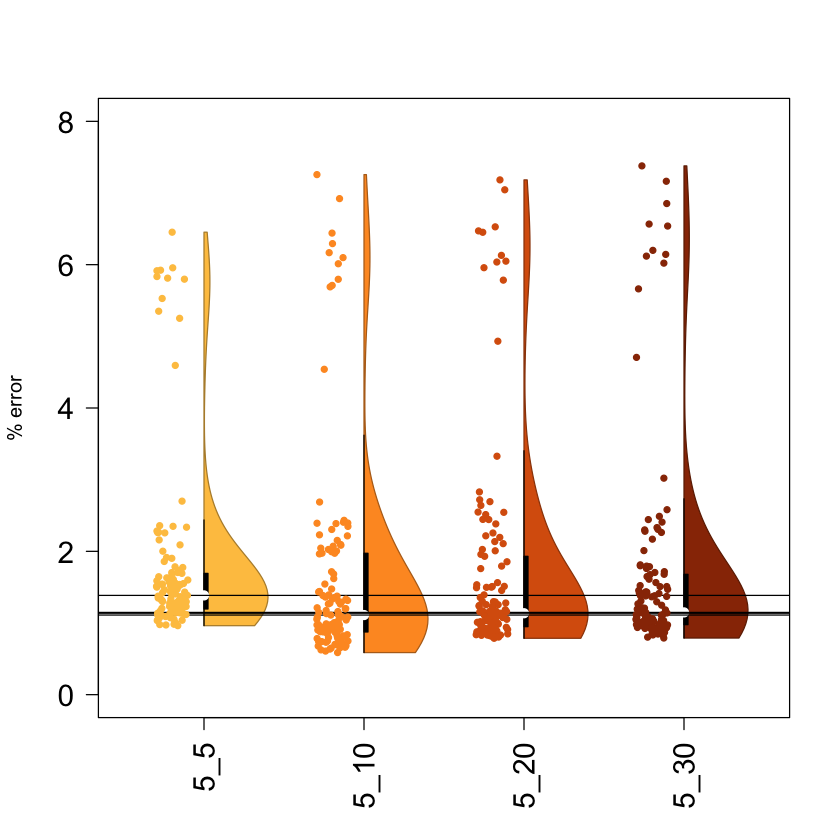

In [12]:
# Get colors
cols <- RColorBrewer::brewer.pal(6, "YlOrBr")[3:6]

# Half violin plots
vioplot::vioplot(lapply(dat_nphenos, function(x) x$average_mean_percent_error),
  col = cols,
  side = "right",
  border = darken_color(cols),
  ylab = "% error",
  xlab = "",
  font.main = 1,
  cex.main = 1.5,
  las = 2,
  ylim = c(0, 8),
  names = names(dat_nphenos),
  cex.axis = 1.5,
  cex.lab = 1.5
)
abline(h = median(dat_nphenos[[1]]$average_mean_percent_error))
abline(h = median(dat_nphenos[[2]]$average_mean_percent_error))
abline(h = median(dat_nphenos[[3]]$average_mean_percent_error))
abline(h = median(dat_nphenos[[4]]$average_mean_percent_error))

stripchart(lapply(dat_nphenos, function(x) x$average_mean_percent_error),
  col = cols,
  at = seq(0.8, (length(dat_nphenos) - 1) + 0.8, 1),
  jitter = 0.1,
  method = "jitter",
  vertical = TRUE,
  cex = 1,
  pch = 20,
  add = TRUE
)

<font size="3"> Calculate error mean and variance as a function of pleiotropy

In [13]:
v <- list()
means <- list()
error <- list()
for (i in 1:length(all_error_nphenos)) {
  v[[i]] <- unlist(lapply(split(
    all_error_nphenos[[i]],
    all_error_nphenos[[i]]$p_pleio
  ), function(x) {
    var(x$mean_percent_error_values) / mean(x$mean_percent_error_values)
  }))
  means[[i]] <- unlist(lapply(split(
    all_error_nphenos[[i]],
    all_error_nphenos[[i]]$p_pleio
  ), function(x) {
    mean(x$mean_percent_error_values)
  }))
  error[[i]] <- unlist(lapply(split(
    all_error_nphenos[[i]],
    all_error_nphenos[[i]]$p_pleio
  ), function(x) {
    plotrix::std.error(x$mean_percent_error_values)
  }))
}

<font size="3"> Plot distribution

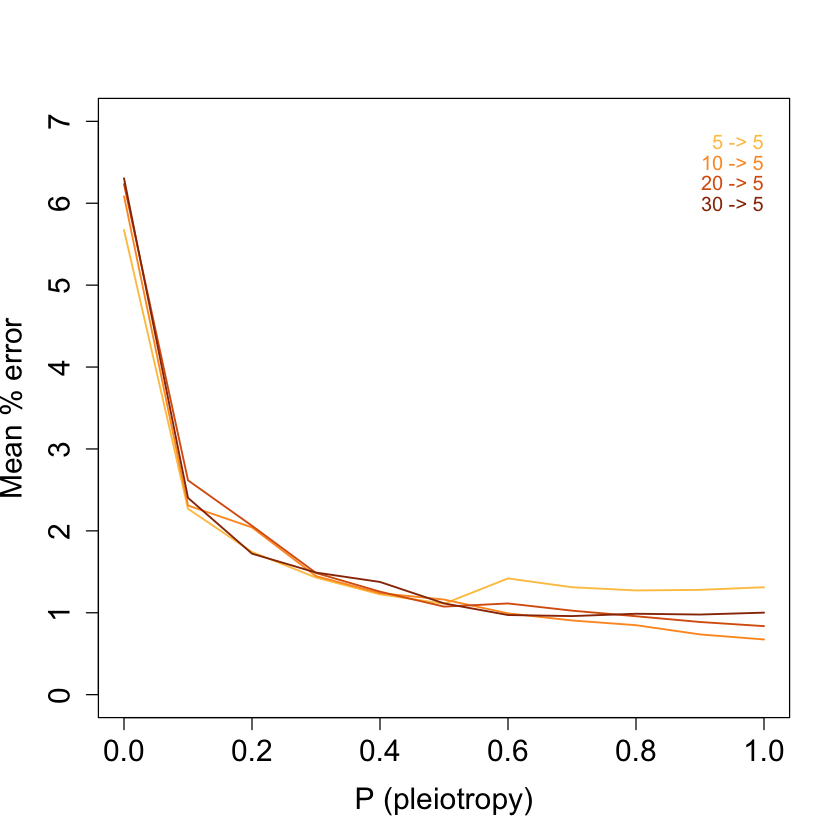

In [15]:
# Get colors
cols <- RColorBrewer::brewer.pal(6, "YlOrBr")[3:6]

# Plot mean
plot(seq(0, 1, 0.1),
  means[[1]],
  type = "l",
  col = cols[1],
  ylim = c(0, 7),
  cex.axis = 1.5,
  cex.lab = 1.5,
  lwd = 1.5,
  ylab = "Mean % error",
  xlab = "P (pleiotropy)"
)
for (i in 2:4) {
  lines(seq(0, 1, 0.1),
    means[[i]],
    col = cols[i],
    lwd = 1.5
  )
}
text(1, 6.75, "5 -> 5", col = cols[1], adj = 1)
text(1, 6.5, "10 -> 5", col = cols[2], adj = 1)
text(1, 6.25, "20 -> 5", col = cols[3], adj = 1)
text(1, 6.0, "30 -> 5", col = cols[4], adj = 1)

## Computing and comparing entropy 

<font size="3"> Split phenotypes on pleiotropy values

In [16]:
pleio <- unlist(lapply(strsplit(names(phens), "_"), function(v) {
  v[4]
}))

<font size="3"> Calculate entropy statistics across all models

In [17]:
toTest <- c(5, 10, 20, 30)
ents <- list()
for (i in 1:length(toTest)) {
  tmp <- list()

  print(paste("n phenotypes =", toTest[i]))

  pb <- txtProgressBar(
    min = 1,
    max = length(phens),
    style = 3,
    width = 50,
    char = "."
  )
  for (j in 1:length(phens)) {
    setTxtProgressBar(pb, j)
    dat <- phens[[j]][sample(nrow(phens[[j]]), 600), 1:toTest[i]]
    tmp[[j]] <- compute.phenotype.stats(list(dat), run_nonlinear = TRUE)
  }
  ents[[as.character(toTest[i])]] <- tmp
}

[1] "n phenotypes = 5"
  |..............................................    |  92%

Warning message in log(freqs):
“NaNs produced”
Warning message in log(freqs):
“NaNs produced”


  |..................................................| 100%[1] "n phenotypes = 10"
  |..............................................    |  92%

<font size="3"> Extract mean entropy per pleiotropy value

In [15]:
stats <- list()
for (i in 1:length(ents)) {
  x <- split(ents[[i]], pleio)
  tmp <- list()
  for (j in 1:length(x)) {
    subsampled_entropy_slopes <- mean(unlist(lapply(x[[j]], function(x) unlist(x$subsampled_entropy_slopes))))
    nonlinearity_aic_ratios <- mean(unlist(lapply(x[[j]], function(x) unlist(x$nonlinearity_aic_ratios))))
    normalized_entropy <- mean(unlist(lapply(x[[j]], function(x) unlist(x$normalized_entropy))))
    mi <- mean(unlist(lapply(x[[j]], function(x) unlist(x$mutual_information))))
    l <- list(
      subsampled_entropy_slopes,
      nonlinearity_aic_ratios,
      normalized_entropy,
      mi
    )
    names(l) <- c(
      "subsampled_entropy_slopes",
      "nonlinearity_aic_ratios",
      "normalized_entropy",
      "mutual_information"
    )
    tmp[[names(x)[j]]] <- l
  }
  stats[[names(ents)[i]]] <- tmp
}

<font size="3"> Plot entropy slope as a function of pleiotropy

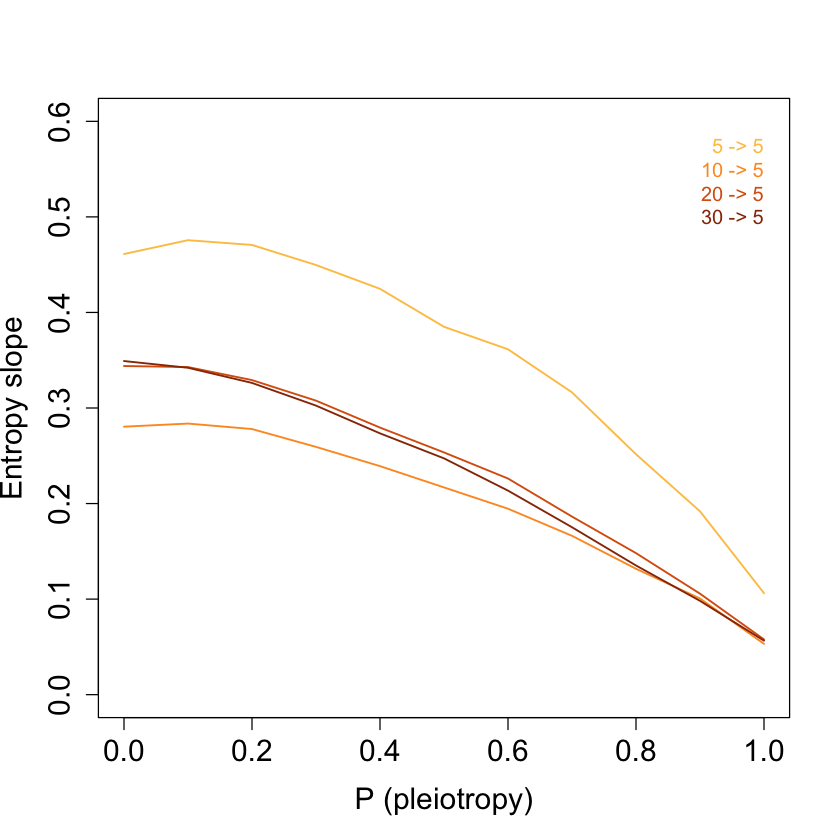

In [16]:
plot(seq(0, 1, 0.1),
  unlist(lapply(stats[[1]], function(x) x$subsampled_entropy_slopes)),
  type = "l",
  col = cols[1],
  ylim = c(0, 0.6),
  cex.axis = 1.5,
  cex.lab = 1.5,
  lwd = 1.5,
  ylab = "Entropy slope",
  xlab = "P (pleiotropy)"
)
for (i in 2:4) {
  lines(seq(0, 1, 0.1),
    unlist(lapply(stats[[i]], function(x) x$subsampled_entropy_slopes)),
    col = cols[i],
    lwd = 1.5
  )
}
text(1, 0.575, "5 -> 5", col = cols[1], adj = 1)
text(1, 0.55, "10 -> 5", col = cols[2], adj = 1)
text(1, 0.525, "20 -> 5", col = cols[3], adj = 1)
text(1, 0.5, "30 -> 5", col = cols[4], adj = 1)

<font size="3"> Compare entropy and error across all models

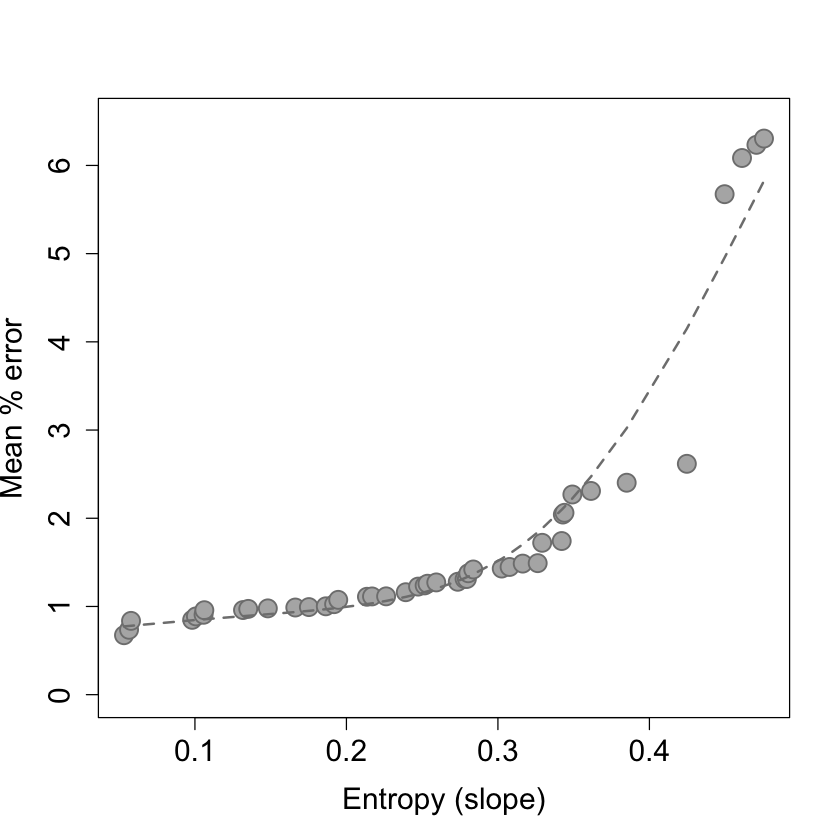

In [17]:
plot(sort(unlist(lapply(stats, function(x) lapply(x, function(y) y$subsampled_entropy_slopes)))),
  sort(unlist(means)),
  xlab = "Entropy (slope)",
  pch = 21,
  bg = "gray70",
  col = "gray50",
  cex = 2,
  ylim = c(0, 6.5),
  cex.axis = 1.5,
  cex.lab = 1.5,
  lwd = 1.5,
  ylab = "Mean % error"
)
s <- smooth.spline(sort(unlist(lapply(stats, function(x) lapply(x, function(y) y$subsampled_entropy_slopes)))),
  sort(unlist(means)),
  spar = 1
)
lines(s$x, s$y, lwd = 2, col = "gray50", lty = "dashed")

<font size="3"> Mean error and entropy per phenotype number

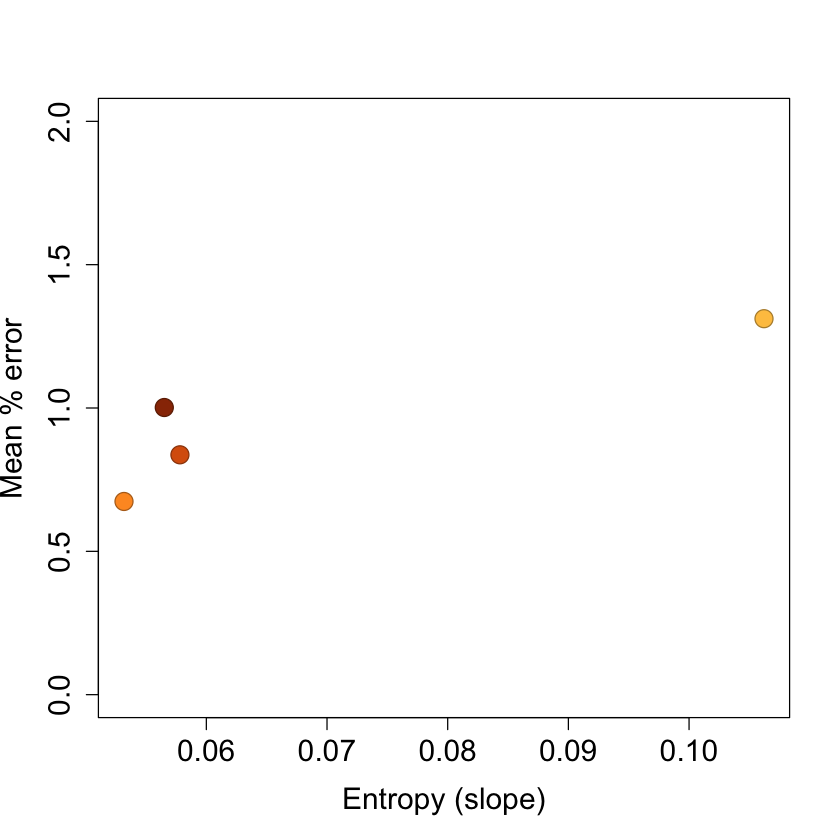

In [18]:
plot(unlist(lapply(stats, function(x) lapply(x, function(y) y$subsampled_entropy_slopes)[11])),
  unlist(lapply(means, function(x) x[11])),
  ylim = c(0, 2),
  pch = 21,
  bg = cols,
  col = darken_color(cols),
  cex = 2,
  xlab = "Entropy (slope)",
  ylab = "Mean % error",
  cex.lab = 1.5,
  cex.axis = 1.5
)